In [1]:
import os
import sys
sys.path.append('/app/BreastAgeNet')

import glob
import random
import pandas as pd
import numpy as np
import openslide
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats
import cv2
import json

from utils.utils_vis import *
from utils.utils_features import *
from utils.utils_model import *
from utils.utils_features import get_model

In [2]:
basedir = '/app/figures/Fig4'
os.listdir(basedir)

['19001626_FPE_3_BreastAgeNet_clusters.json',
 'lobule_patches.csv',
 'lobule_patches_reinhard_UNI_features.h5',
 'lobule_type_QuPath_measures.csv',
 'lobule_type_annotations.png',
 'test_NR_phenotype_reference.csv']

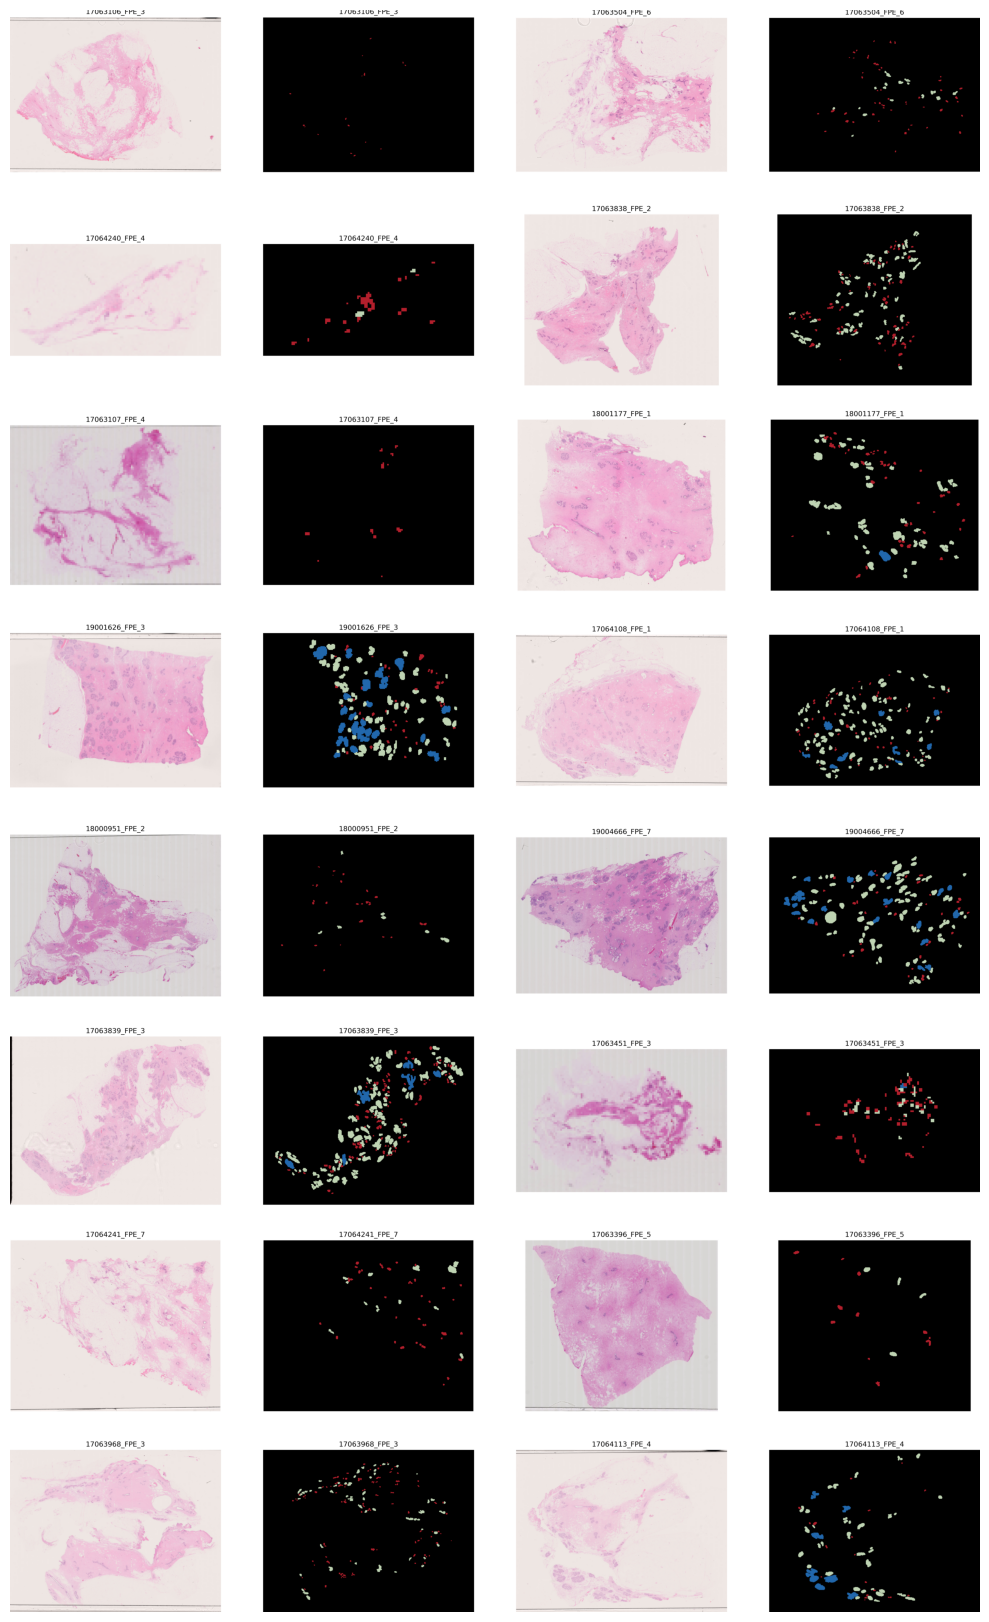

In [3]:
# lobule type manual annotations
img = Image.open(f"{basedir}/lobule_type_annotations.png")
plt.figure(figsize=(10, 18)) 
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# QuPath quantification of lobules
lobules_df = pd.read_csv(f"{basedir}/lobule_type_QuPath_measures.csv")
lobules_df.head()

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Perimeter µm,lobule_type,wsi_id,age_group
0,19001626_FPE_3.ndpi,a7d3f37e-bae0-4e9e-b67f-9b44b57cc9a7,Annotation,NaN,1,Root object (Image),Polygon,19328.0,6683.4,22950.0,576.05,type1,19001626_FPE_3,0.0
1,19001626_FPE_3.ndpi,4ed94fda-fbcb-4b46-baea-8f7fd4b33ab7,Annotation,NaN,2,Root object (Image),Polygon,27996.5,19376.0,80447.5,1053.60,type2,19001626_FPE_3,0.0
2,19001626_FPE_3.ndpi,89403d6c-c0c8-4c5b-bfad-7fb8f9b1d609,Annotation,NaN,2,Root object (Image),Polygon,15337.0,17833.2,918852.4,3645.60,type2,19001626_FPE_3,0.0
3,19001626_FPE_3.ndpi,56a0310b-ce75-4aae-924e-cfac6114dcd2,Annotation,NaN,1,Root object (Image),Polygon,18901.3,14723.7,6352.4,292.46,type1,19001626_FPE_3,0.0
4,19001626_FPE_3.ndpi,b1994448-ec7b-4dff-a7f6-49787b2b58fe,Annotation,NaN,2,Root object (Image),Geometry,13577.3,11624.8,204196.8,1761.00,type2,19001626_FPE_3,0.0


In [5]:
# Pairwise comparison of lobule's size between lobule types (Wilcoxon rank-sum test)
pval_df = compute_adjusted_pvalues(df=lobules_df, features=['Area µm^2'], group_label='lobule_type', 
                                   group_order=['type1', 'type2', 'type3'], save_pt=None)
pval_df.head()

,Feature,Group 1,Group 2,Adjusted p-value,Significance
0,Area µm^2,type1,type2,5.221229e-183,***
1,Area µm^2,type1,type3,3.210352e-42,***
2,Area µm^2,type2,type3,8.389231e-35,***


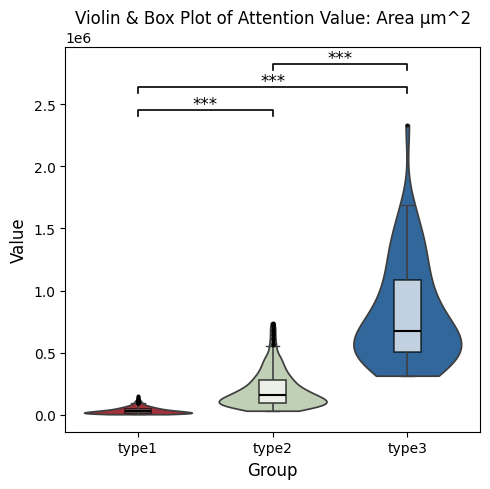

In [6]:
# Violin plot showing the pairwise comparison of lobule's size between lobule types
feature = 'Area µm^2'
group_label = 'lobule_type'
group_order = ['type1', 'type2', 'type3']
group_colors = {'type1': '#B31F2C', 'type2': '#BFD4B3', 'type3': '#2167AC'}

fig, ax = plt.subplots(figsize=(5, 5)) 
violin_boxplot_with_pvalue(lobules_df, feature, group_label, group_order, group_colors, pval_df, ax=ax)
plt.tight_layout()
plt.show()

In [7]:
# Association between lobule types and ground-truth tissue ageing ranks (Chi-square test)
contingency_table = pd.crosstab(lobules_df["age_group"], lobules_df["lobule_type"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
significance = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e} {significance}")
if significance != 'ns':
    print(f"Significant association found between age_group and Pattern ({significance}).")
else:
    print("No significant association found between age_group and Pattern.")

Chi-square statistic: 156.7832
Degrees of freedom: 6
P-value: 2.8415e-31 ***
Significant association found between age_group and Pattern (***).


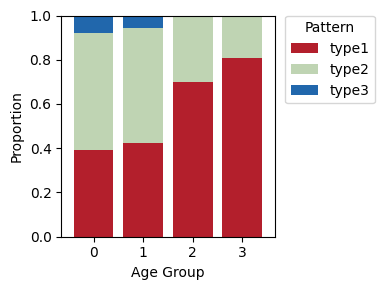

In [8]:
# Stacked barplot showing association between lobule types and ground-truth tissue ageing ranks
age_group_order = [0, 1, 2, 3]
lobule_type_order = ['type1', 'type2', 'type3']
group_colors = {'type1': '#B31F2C', 'type2': '#BFD4B3', 'type3': '#2167AC'}

counts = lobules_df.groupby(["age_group", "lobule_type"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[age_group_order, lobule_type_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=True, color=[group_colors[p] for p in lobule_type_order], ax=ax, width=0.8)
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_xticklabels(age_group_order, rotation=0)
ax.set_ylim(0, 1)  
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

In [9]:
# obtain tessellated patches from lobules
patch_df = pd.read_csv(f'{basedir}/lobule_patches.csv')
patch_df.head()

,wsi_id,lobule_type,file_path,patch_id
0,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png",17063106_FPE_3_62464_78848_512_512
1,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png",17063106_FPE_3_73728_41984_512_512
2,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png",17063106_FPE_3_29184_78336_512_512
3,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png",17063106_FPE_3_67072_100352_512_512
4,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png",17063106_FPE_3_85504_95744_512_512


In [21]:
# # extract UNI features for tessellated lobule patches
# from utils.utils_features import get_model
# model_name='UNI'
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(f"device: {device}")
# model, transform = get_model(model_name, device)
# print(f"model_name: {model_name}")

# bag_dataset = Dataset_frompatch(patch_df=patch_df, stainFunc="reinhard", transforms_eval=transform)
# batch_size = 16
# num_workers = 2
# fname = f'{basedir}/lobule_patches_reinhard_UNI_features.h5'
# extract_features(model, bag_dataset, batch_size, num_workers, device, fname)

In [11]:
# load UNI features
fname = f'{basedir}/lobule_patches_reinhard_UNI_features.h5'
with h5py.File(fname, "r") as file:
    bag = np.array(file["embeddings"])
    bag = np.squeeze(bag)
    img_id = np.array(file["patch_id"])
img_id = [i.decode("utf-8") for i in img_id]
img_id = list(patch_df["patch_id"])
UNI_features = pd.DataFrame(bag)
UNI_features.index = img_id
UNI_features.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
17063106_FPE_3_62464_78848_512_512,-0.484880,0.030179,-0.433205,0.152808,0.599169,-1.237504,1.215462,0.615942,-2.055577,-0.315147,...,-0.102305,0.704042,-0.997408,2.352842,0.505401,-0.382233,-1.226270,-0.023502,-0.391646,-1.457612
17063106_FPE_3_73728_41984_512_512,-0.433122,-1.438849,-1.091678,-0.147458,-0.159438,-0.929984,1.539030,0.404922,-0.974436,-0.303149,...,-0.132456,-1.514029,-1.014341,1.540514,0.848650,0.112853,-0.416730,0.041735,-0.153870,-3.643915
17063106_FPE_3_29184_78336_512_512,-0.164743,0.772967,-0.056225,0.668153,0.667503,-2.219481,-0.320257,-0.890860,-2.119389,-0.322502,...,2.134860,-1.378677,-0.725245,-0.220276,0.221198,-0.845110,-1.261437,0.393659,-1.358745,-2.365382
17063106_FPE_3_67072_100352_512_512,-1.520631,-0.860602,-1.646921,-0.646256,0.710684,-2.056589,2.124591,-0.372010,-1.413393,0.217080,...,-0.350082,-0.258929,-2.092872,0.769861,0.559805,-0.945595,-1.168555,0.195331,-0.108394,-0.133926
17063106_FPE_3_85504_95744_512_512,-0.737497,-0.130265,-0.041434,-0.452685,0.069676,-1.918865,0.364256,-0.026659,-0.926109,-0.850618,...,-0.573647,-0.776938,-0.119714,2.993517,0.413058,-0.139344,-0.012788,-0.210723,-1.460703,-1.408041


In [12]:
# load BreastAgeNet
ckpt_pt = "/app/BreastAgeNet/weights/epi0.9_UNI_250_MultiHeadAttention_full_best.pt"
model = load_BreastAgeNet(ckpt_pt, embed_attn=True)
phase = 'test'
model.eval()

cuda


BreastAgeNet(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (attentions): ModuleList(
    (0-2): 3 x MultiHeadAttention(
      (q_proj): Linear(in_features=512, out_features=512, bias=True)
      (k_proj): Linear(in_features=512, out_features=512, bias=True)
      (fc): Linear(in_features=8, out_features=1, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (classifiers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [13]:
# OLD: run BreastAgeNet to obtain patch-level features and predictions
bag_size=250
batch_size=256
wsiloader = WSI_loader(UNI_features, batch_size, bag_size)

breastagenet_features = pd.DataFrame()  
for patch_ids, inputs in tqdm(wsiloader):
    patch_ids = np.array(patch_ids)
    patch_ids = np.transpose(patch_ids)
    patch_ids = patch_ids.flatten()
    with torch.set_grad_enabled(phase == 'train'):
        logits, embeddings, attentions = model(inputs)
        attentions = attentions.view(-1, attentions.shape[-1])  # Flatten attentions
        embeddings = embeddings.view(-1, embeddings.shape[-1])  # Flatten embeddings
    combined_data = np.column_stack((patch_ids, embeddings.cpu().numpy(), attentions.cpu().numpy())) 
    dfi = pd.DataFrame(combined_data, columns=['patch_id'] + [f'embedding_{i}' for i in range(embeddings.shape[1])] + [f'attention_{i}' for i in range(attentions.shape[1])]) 
    breastagenet_features = pd.concat([breastagenet_features, dfi], axis=0) 
    
breastagenet_features = pd.merge(patch_df, breastagenet_features, on="patch_id", how="left")
breastagenet_features.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


,wsi_id,lobule_type,file_path,patch_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511,attention_0,attention_1,attention_2
0,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png",17063106_FPE_3_62464_78848_512_512,0.9217812,0.36882123,0.03596104,0.59019035,0.0,0.0,...,1.3418593,0.5291363,0.0,0.73866343,0.0,0.5527793,0.7712023,0.9165572,-0.8857504,-1.3203081
1,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png",17063106_FPE_3_73728_41984_512_512,0.478114,0.2720324,0.19906642,1.5095336,0.29287848,0.0,...,1.8390265,0.7358821,0.0,0.46586445,0.5953733,0.0031505674,0.0,3.4128065,1.8843544,-0.83048725
2,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png",17063106_FPE_3_29184_78336_512_512,1.5184342,1.6895329,0.0,0.699756,0.0,0.0,...,1.74936,0.61942136,0.0,0.78254765,0.10189261,1.1877297,0.3979532,1.206236,-0.20509899,1.1987064
3,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png",17063106_FPE_3_67072_100352_512_512,0.95433635,0.44130325,0.54870266,0.0,0.0,0.0,...,1.1777815,0.7678458,0.41375118,0.069348924,1.0469545,1.1919101,0.0,-0.05324346,-2.1902413,-3.220851
4,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png",17063106_FPE_3_85504_95744_512_512,0.0,1.1290969,0.0,1.2218682,0.0,0.0,...,1.2645359,0.43688357,0.895445,0.91644853,0.02695376,0.0,0.8702642,1.6952008,-0.5410704,-2.8710022


In [14]:
# Pairwise comparison of branch-specific attention between lobule types (Wilcoxon rank-sum test)
features=["attention_0", "attention_1", "attention_2"] 
group_label = "lobule_type"
group_order = ['type1', 'type2', 'type3']
group_colors = {"type1": "#b31f2c", "type2": "#bfd4b3", "type3": "#2167ac"}

pval_df = compute_adjusted_pvalues(df=breastagenet_features, features=["attention_0", "attention_1", "attention_2"], 
                                   group_label = "lobule_type", group_order = ['type1', 'type2', 'type3'], save_pt=None)
print(pval_df)

       Feature Group 1 Group 2  Adjusted p-value Significance
0  attention_0   type1   type2      4.959159e-10          ***
1  attention_0   type1   type3      1.045588e-01             
2  attention_0   type2   type3      5.640810e-15          ***
3  attention_1   type1   type2      7.495393e-01             
4  attention_1   type1   type3      5.663043e-01             
5  attention_1   type2   type3      2.430871e-01             
6  attention_2   type1   type2      6.833437e-28          ***
7  attention_2   type1   type3      2.115047e-76          ***
8  attention_2   type2   type3      1.635957e-36          ***


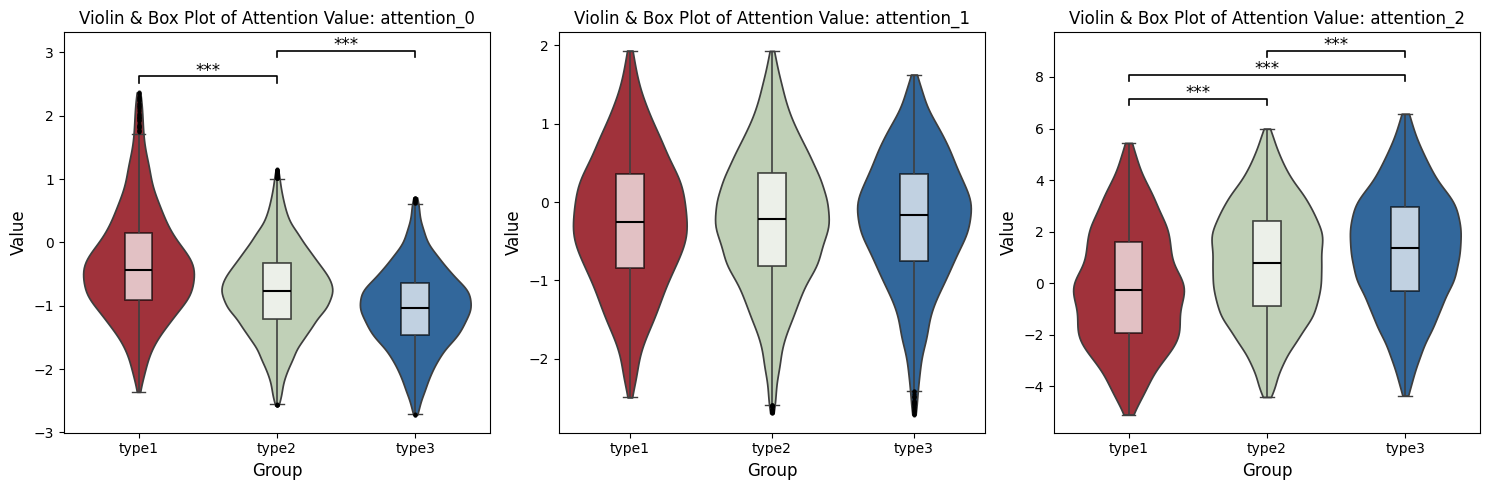

In [15]:
# Violin plot showing the pairwise comparison of branch-specific attention between lobule types
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(features):
    violin_boxplot_with_pvalue(breastagenet_features, feature, group_label, group_order, group_colors, pval_df, ax=axes[i])

plt.tight_layout()
plt.show()

In [16]:
# train a Kmeans model
reference = pd.read_csv(f"{basedir}/test_NR_phenotype_reference.csv")
kmeans_model = train_kmeans(reference, n_clusters=4)

# predict ageing phenotypes
breastagenet_features = apply_kmeans(breastagenet_features, reference, kmeans_model)
breastagenet_features["Pattern"] = [f"P{i}" for i in list(breastagenet_features["Cluster"])]
breastagenet_features.head()

Label Mapping: {3: 0, 0: 1, 1: 2, 2: 3}


,wsi_id,lobule_type,file_path,patch_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511,attention_0,attention_1,attention_2,Cluster,Pattern
0,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png",17063106_FPE_3_62464_78848_512_512,0.921781,0.368821,0.035961,0.590190,0.000000,0.0,...,0.000000,0.738663,0.000000,0.552779,0.771202,0.916557,-0.885750,-1.320308,2,P2
1,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png",17063106_FPE_3_73728_41984_512_512,0.478114,0.272032,0.199066,1.509534,0.292878,0.0,...,0.000000,0.465864,0.595373,0.003151,0.000000,3.412806,1.884354,-0.830487,2,P2
2,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png",17063106_FPE_3_29184_78336_512_512,1.518434,1.689533,0.000000,0.699756,0.000000,0.0,...,0.000000,0.782548,0.101893,1.187730,0.397953,1.206236,-0.205099,1.198706,1,P1
3,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png",17063106_FPE_3_67072_100352_512_512,0.954336,0.441303,0.548703,0.000000,0.000000,0.0,...,0.413751,0.069349,1.046955,1.191910,0.000000,-0.053243,-2.190241,-3.220851,2,P2
4,17063106_FPE_3,type1,"/data/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png",17063106_FPE_3_85504_95744_512_512,0.000000,1.129097,0.000000,1.221868,0.000000,0.0,...,0.895445,0.916449,0.026954,0.000000,0.870264,1.695201,-0.541070,-2.871002,2,P2


In [17]:
# Association between lobule types and ageing phenotypes (Chi-square test)
contingency_table = pd.crosstab(breastagenet_features["Pattern"], breastagenet_features["lobule_type"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
significance = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e} {significance}")
if significance != 'ns':
    print(f"Significant association found between age_group and Pattern ({significance}).")
else:
    print("No significant association found between age_group and Pattern.")

Chi-square statistic: 887.8624
Degrees of freedom: 6
P-value: 1.5801e-188 ***
Significant association found between age_group and Pattern (***).


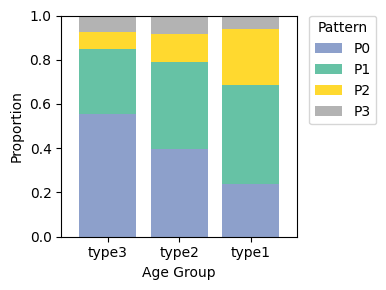

In [18]:
# Stacked barplot showing association between lobule types and ageing phenotypes (Chi-square test)
age_pattern_order = ['P0', 'P1', 'P2', 'P3']
lobule_type_order = ['type3', 'type2', 'type1']
pattern_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

counts = breastagenet_features.groupby(["lobule_type", "Pattern"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[lobule_type_order, age_pattern_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=True, color=[pattern_colors[p] for p in age_pattern_order], ax=ax, width=0.8)
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_xticklabels(lobule_type_order, rotation=0)
ax.set_ylim(0, 1)  
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

/opt/conda/envs/breastagenet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


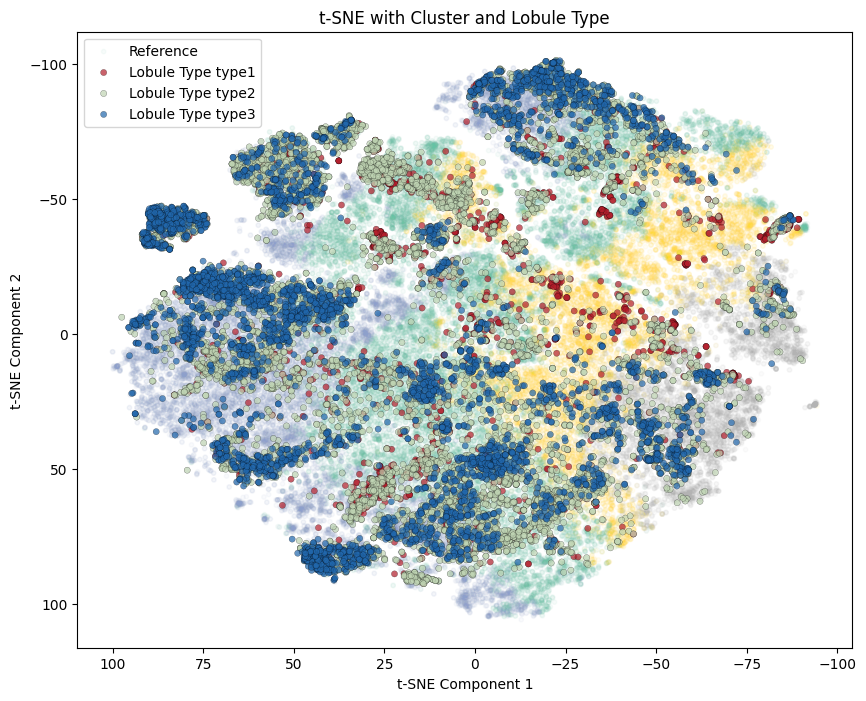

In [19]:
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
breastagenet_features, reference  = highlight_a_WSI_in_tsne(breastagenet_features, reference, cluster_colors, save_pt=None)

Label Mapping: {3: 0, 0: 1, 1: 2, 2: 3}


/opt/conda/envs/breastagenet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


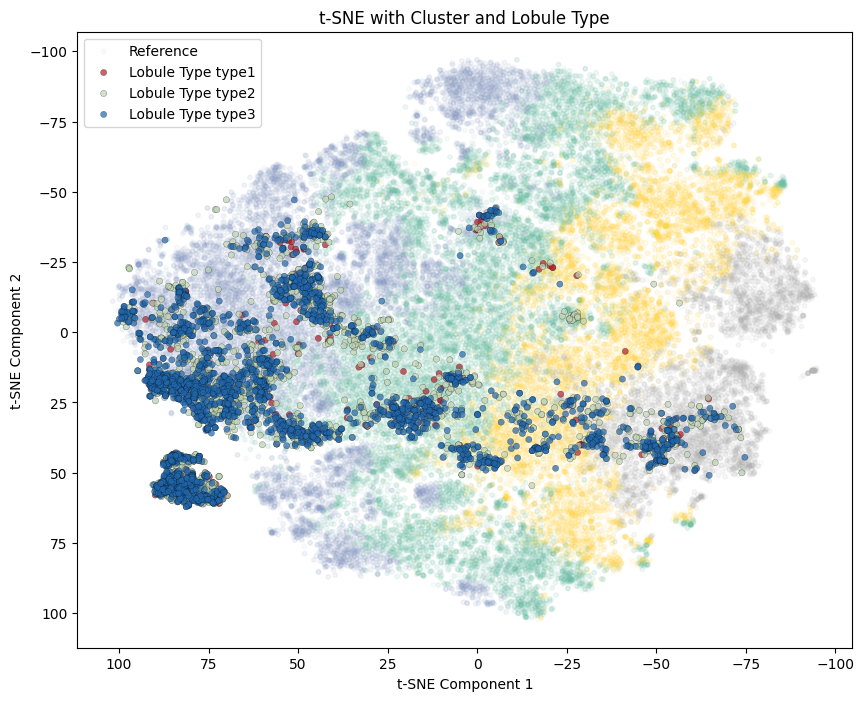

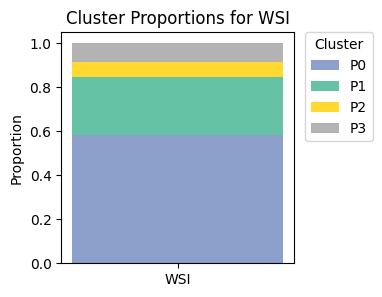

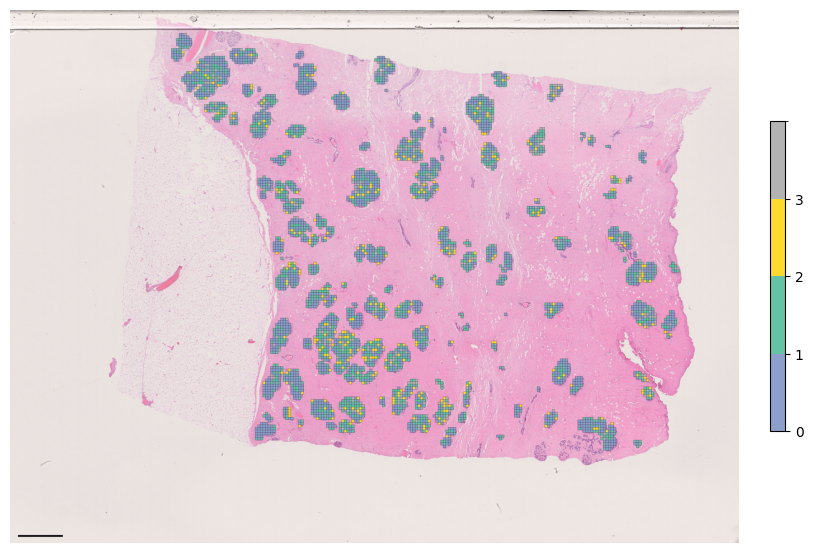

/app/figures/Fig4/19001626_FPE_3_BreastAgeNet_clusters.json saved!


In [20]:
# predict ageing phenotypes for a single WSI
wsi_id = "19001626_FPE_3"
new_df = breastagenet_features.loc[breastagenet_features['wsi_id'] == wsi_id, :].copy()
new_df = apply_kmeans(new_df, reference, kmeans_model)

# visualise the WSI in reference tsne
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
new_df, reference  = highlight_a_WSI_in_tsne(new_df, reference, cluster_colors, save_pt=None)

# show cluster proportions of the WSI
plot_cluster_proportion_for_a_WSI(new_df, save_pt=None, normalize=True)

# overlay clusters on the WSI
new_df["patch_size"] = [int(i.split("_")[-1]) for i in new_df["patch_id"]]
new_df["x_orig"] = [int(i.split("_")[-4]) for i in new_df["patch_id"]]
new_df["y_orig"] = [int(i.split("_")[-3]) for i in new_df["patch_id"]]
new_df = new_df.loc[new_df["patch_size"] == 512, :].copy()

wsi_path = glob.glob(f"/app/example_data/WSIs/KHP_NR/19001626_FPE_3.ndpi")[0]
new_df, wsi_img = draw_wsi_with_clusters(new_df, wsi_path, cluster_colors, level=5, save_pt=None)

# export QuPath JSON file
clusters_json_for_a_WSI(new_df, wsi_id, cluster_colors, json_dir=basedir, require_bounds=False)